# Extending NumPy

Many new features can be integrated with NumPy machinery:

* dtypes,
* ufuncs and gufuncs,
* new C code directly with NumPy arays

## Creating ufuncs

By creating a new ufunc you will obtain a function that handles

* broadcasting
* N-dimensional looping
* automatic type-conversions with minimal memory usage
* optional output arrays

In [1]:
%load_ext cython

The following example is taken from [Advanced Numpy](http://www.scipy-lectures.org/advanced/advanced_numpy/index.html#exercise-building-an-ufunc-from-scratch) chapter of SciPy lectures by Pauli Virtanen

In [2]:
%%cython

# The elementwise function
# ------------------------

cdef void mandel_single_point(double complex *z_in, 
                              double complex *c_in,
                              double complex *z_out) nogil:
    #
    # The Mandelbrot iteration
    #

    #
    # Some points of note:
    #
    # - It's *NOT* allowed to call any Python functions here.
    #
    #   The Ufunc loop runs with the Python Global Interpreter Lock released.
    #   Hence, the ``nogil``.
    #
    # - And so all local variables must be declared with ``cdef``
    #
    # - Note also that this function receives *pointers* to the data;
    #   the "traditional" solution to passing complex variables around
    #

    cdef double complex z = z_in[0]
    cdef double complex c = c_in[0]
    cdef int k  # the integer we use in the for loop

    # Straightforward iteration

    for k in range(100):
        z = z*z + c
        if z.real**2 + z.imag**2 > 1000:
            break

    # Return the answer for this point
    z_out[0] = z



# Required module initialization
# ------------------------------

cimport numpy as np
np.import_array()
np.import_ufunc()

# The actual ufunc declaration
# ----------------------------

cdef np.PyUFuncGenericFunction loop_func[1]
cdef char input_output_types[3]
cdef void *elementwise_funcs[1]

loop_func[0] = np.PyUFunc_DD_D # generic function to implement looping

input_output_types[0] = np.NPY_CDOUBLE
input_output_types[1] = np.NPY_CDOUBLE
input_output_types[2] = np.NPY_CDOUBLE

elementwise_funcs[0] = <void*>mandel_single_point

mandel = np.PyUFunc_FromFuncAndData(
    loop_func,
    elementwise_funcs,
    input_output_types,
    1, # number of supported input types
    2, # number of input args
    1, # number of output args
    0, # `identity` element, never mind this
    "mandel", # function name
    "mandel(z, c) -> computes iterated z*z + c", # docstring
    0 # unused
    )


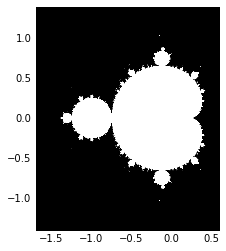

In [3]:
"""
Plot Mandelbrot
================

Plot the Mandelbrot ensemble.

"""

import numpy as np
x = np.linspace(-1.7, 0.6, 1000)
y = np.linspace(-1.4, 1.4, 1000)
c = x[None,:] + 1j*y[:,None]
z = mandel(c, c)

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(abs(z)**2 < 1000, extent=[-1.7, 0.6, -1.4, 1.4])
plt.gray()
plt.show()

Many external libraries (like numba) greatly simplify writing ufuncs.

### Exercise

Take the following function calculating logit and turn it into a ufunc using the above example.

```cython

cdef extern from "math.h":
    double log "log" (double) nogil
    
import cython

@cython.cdivision(True)
cdef double logit_double(double p) nogil:
    p = p/(1-p);
    p = log(p);
    return p
```

## Further reading

* SciPy Lecture: http://www.scipy-lectures.org/advanced/advanced_numpy/index.html#exercise-building-an-ufunc-from-scratch
* Writing your own ufuncs: http://docs.scipy.org/doc/numpy/user/c-info.ufunc-tutorial.html
* How to extend NumPy: http://docs.scipy.org/doc/numpy/user/c-info.how-to-extend.html